In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import os

In [2]:
#function to split the data into training, validation and test sets, and calculate their Fourier coefficients along
#with the corresponding labels. At t=0 all of the signals are equal, so we omit the first timestep. Ntrain is the 
#number of trajectories in the training set, Nval is the number in the validation set and Ntest is the number in 
#the test set
def fouriertrainvaltest(X, Y, Ntrain, Nval, Ntest):
    
    #Generating a training set with Ntrain trajectories, a validation with Nval trajectories and a test set with
    #Ntest trajectories. At t=0 all of the signals are equal, so we omit the first timestep.
    Xtrain = X[0:Ntrain, 1:401]
    Xval = X[Ntrain:Ntrain+Nval, 1:401]
    Xtest = X[Ntrain+Nval:Ntrain+Nval+Ntest, 1:401]

    #extract the corresponding labels for the training, validation and test sets.
    Ytrain = Y[0:Ntrain, :]
    Yval = Y[Ntrain:Ntrain+Nval, :]
    Ytest = Y[Ntrain+Nval:Ntrain+Nval+Ntest, :]
    
    #calculating the Fourier coefficients for each subset.
    XtrainF = np.fft.fft(Xtrain)
    XvalF = np.fft.fft(Xval)
    XtestF = np.fft.fft(Xtest)
    
    #Prepare to split the Fourier coefficients into their real and imaginary components. Each complex number will 
    #occupy two columns: one for the real part and one for the imaginary part. Therefore, we create new arrays that 
    #have twice the number of columns. 
    xtrain = np.zeros((XtrainF.shape[0], 2*XtrainF.shape[1]))
    xval = np.zeros((XvalF.shape[0], 2*XvalF.shape[1]))
    xtest = np.zeros((XtestF.shape[0], 2*XtestF.shape[1]))

    #For each Fourier coefficient in the training set, split into real and imaginary parts. These parts are then
    #stored alternately (even indices for real, odd indices for imaginary).
    for i in range(XtrainF.shape[0]):
        for j in range(XtrainF.shape[1]):
            xtrain[i, 2*j] = XtrainF[i,j].real
            xtrain[i, 2*j + 1] = XtrainF[i,j].imag
        
    #Do the same for the test set, splitting the Fourier coefficients into their real and imaginary parts.
    for i in range(XtestF.shape[0]):
        for j in range(XtestF.shape[1]):
            xtest[i, 2*j] = XtestF[i,j].real
            xtest[i, 2*j + 1] = XtestF[i,j].imag
            
    #Similarly, split the Fourier coefficients for the validation set.
    for i in range(XvalF.shape[0]):
        for j in range(XvalF.shape[1]):
            xval[i, 2*j] = XvalF[i,j].real
            xval[i, 2*j + 1] = XvalF[i,j].imag
            
    #Return the transformed training, validation and test sets along with their corresponding labels
    return(xtrain, xval, xtest, Ytrain, Yval, Ytest)

In [3]:
#Function to calculate the R-squared metric. This function takes the true and predicted values, and calculates the 
#R-squared value
def r_square(y, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
    r2 = 1 - residual/total
    return(r2)

In [4]:
#Loading the data with $\eta = 0.25$, $\omega_c = 0.5$ with $s \in (0, 0.5]$ if the spectral density is sub-Ohmic,
#$s \in [1.5, 4]$ is the spectral density is super-Ohmic and $s=1$ is the spectral density is Ohmic.
X_separated = np.loadtxt('Data/Xtrainx_fixedηandω_separated.csv', delimiter=',')
Y_separated = np.loadtxt('Data/Ytrain_fixedηandω_separated.csv', delimiter=',')

In [5]:
#Y_separated[:,[4]] selects the column with the Ohmicity parameter, located at index 4
Y_separateds = Y_separated[:,[4]]

#Scale the labels using MinMaxScaler for normalisation
scaler=MinMaxScaler()
Y_separateds_scaled = scaler.fit_transform(Y_separateds)

#Generating a training, validation and test set 
xtrain_separated, xval_separated, xtest_separated, Ytrain_separated, Yval_separated, Ytest_separated = fouriertrainvaltest(X_separated, Y_separateds_scaled, 4800, 2400, 2400)

In [6]:
#Define the path where the model's weights will be saved
checkpoint_path = "training_regressions_separated.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [15]:
#Create a sequential model
model_separated = tf.keras.Sequential()
#Add the hidden layers
model_separated.add(tf.keras.layers.Dense(250, input_dim = (np.shape(xtrain_separated)[1]), activation='sigmoid'))
model_separated.add(tf.keras.layers.Dense(80 , activation = 'sigmoid'))
#Add the output layer
model_separated.add(tf.keras.layers.Dense(1, activation = 'linear'))

#Setting the optimiser equal to the Adam optimiser with learning rate = 0.0001
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)

#Compliling the model
model_separated.compile(optimizer=opt, loss = 'mean_absolute_error', metrics=[r_square])

#Training the model
history_separated = model_separated.fit(xtrain_separated, Ytrain_separated, epochs = 1000, validation_data = (xval_separated, Yval_separated), batch_size = np.shape(xtrain_separated)[0], verbose=1, callbacks=[cp_callback])

Epoch 1/1000
1/1 [==============================] - ETA: 0s - loss: 0.3754 - r_square: -1.1854

2024-10-17 15:10:57.026383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-10-17 15:10:57.189157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 422ms/step - loss: 0.3754 - r_square: -1.1854 - val_loss: 0.3413 - val_r_square: -0.7474
Epoch 2/1000
1/1 [==============================] - ETA: 0s - loss: 0.3401 - r_square: -0.7667
Epoch 2: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 41ms/step - loss: 0.3401 - r_square: -0.7667 - val_loss: 0.3111 - val_r_square: -0.4410
Epoch 3/1000
1/1 [==============================] - ETA: 0s - loss: 0.3082 - r_square: -0.4495
Epoch 3: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 44ms/step - loss: 0.3082 - r_square: -0.4495 - val_loss: 0.2840 - val_r_square: -0.2269
Epoch 4/1000
1/1 [==============================] - ETA: 0s - loss: 0.2796 - r_square: -0.2278
Epoch 4: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 42ms/step - l

1/1 [==============================] - 0s 34ms/step - loss: 0.0366 - r_square: 0.9728 - val_loss: 0.0332 - val_r_square: 0.9757
Epoch 30/1000
1/1 [==============================] - ETA: 0s - loss: 0.0318 - r_square: 0.9762
Epoch 30: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0318 - r_square: 0.9762 - val_loss: 0.0376 - val_r_square: 0.9752
Epoch 31/1000
1/1 [==============================] - ETA: 0s - loss: 0.0364 - r_square: 0.9758
Epoch 31: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0364 - r_square: 0.9758 - val_loss: 0.0375 - val_r_square: 0.9762
Epoch 32/1000
1/1 [==============================] - ETA: 0s - loss: 0.0362 - r_square: 0.9770
Epoch 32: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0362 - r_square: 0.9770 - val_loss: 0.0339 - val_r_square: 0.9778

Epoch 58/1000
1/1 [==============================] - ETA: 0s - loss: 0.0149 - r_square: 0.9941
Epoch 58: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0149 - r_square: 0.9941 - val_loss: 0.0132 - val_r_square: 0.9953
Epoch 59/1000
1/1 [==============================] - ETA: 0s - loss: 0.0128 - r_square: 0.9953
Epoch 59: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0128 - r_square: 0.9953 - val_loss: 0.0156 - val_r_square: 0.9957
Epoch 60/1000
1/1 [==============================] - ETA: 0s - loss: 0.0152 - r_square: 0.9958
Epoch 60: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0152 - r_square: 0.9958 - val_loss: 0.0160 - val_r_square: 0.9957
Epoch 61/1000
1/1 [==============================] - ETA: 0s - loss: 0.0155 - r_square: 0.9958
Epoch 61: saving model to traini

1/1 [==============================] - ETA: 0s - loss: 0.0048 - r_square: 0.9996
Epoch 114: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 45ms/step - loss: 0.0048 - r_square: 0.9996 - val_loss: 0.0106 - val_r_square: 0.9984
Epoch 115/1000
1/1 [==============================] - ETA: 0s - loss: 0.0106 - r_square: 0.9984
Epoch 115: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 39ms/step - loss: 0.0106 - r_square: 0.9984 - val_loss: 0.0050 - val_r_square: 0.9995
Epoch 116/1000
1/1 [==============================] - ETA: 0s - loss: 0.0050 - r_square: 0.9995
Epoch 116: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0050 - r_square: 0.9995 - val_loss: 0.0090 - val_r_square: 0.9987
Epoch 117/1000
1/1 [==============================] - ETA: 0s - loss: 0.0090 - r_square: 0.9987
Epoch 117: saving model to training_regr

1/1 [==============================] - ETA: 0s - loss: 0.0028 - r_square: 0.9999
Epoch 142: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 36ms/step - loss: 0.0028 - r_square: 0.9999 - val_loss: 0.0090 - val_r_square: 0.9989
Epoch 143/1000
1/1 [==============================] - ETA: 0s - loss: 0.0090 - r_square: 0.9989
Epoch 143: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 49ms/step - loss: 0.0090 - r_square: 0.9989 - val_loss: 0.0069 - val_r_square: 0.9993
Epoch 144/1000
1/1 [==============================] - ETA: 0s - loss: 0.0069 - r_square: 0.9993
Epoch 144: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 39ms/step - loss: 0.0069 - r_square: 0.9993 - val_loss: 0.0062 - val_r_square: 0.9994
Epoch 145/1000
1/1 [==============================] - ETA: 0s - loss: 0.0063 - r_square: 0.9994
Epoch 145: saving model to training_regr

1/1 [==============================] - ETA: 0s - loss: 0.0022 - r_square: 0.9999
Epoch 170: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0022 - r_square: 0.9999 - val_loss: 0.0064 - val_r_square: 0.9994
Epoch 171/1000
1/1 [==============================] - ETA: 0s - loss: 0.0064 - r_square: 0.9994
Epoch 171: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0064 - r_square: 0.9994 - val_loss: 0.0036 - val_r_square: 0.9998
Epoch 172/1000
1/1 [==============================] - ETA: 0s - loss: 0.0036 - r_square: 0.9998
Epoch 172: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0036 - r_square: 0.9998 - val_loss: 0.0083 - val_r_square: 0.9991
Epoch 173/1000
1/1 [==============================] - ETA: 0s - loss: 0.0083 - r_square: 0.9991
Epoch 173: saving model to training_regr

1/1 [==============================] - ETA: 0s - loss: 0.0019 - r_square: 0.9999
Epoch 198: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0019 - r_square: 0.9999 - val_loss: 0.0045 - val_r_square: 0.9997
Epoch 199/1000
1/1 [==============================] - ETA: 0s - loss: 0.0045 - r_square: 0.9997
Epoch 199: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0045 - r_square: 0.9997 - val_loss: 0.0016 - val_r_square: 0.9999
Epoch 200/1000
1/1 [==============================] - ETA: 0s - loss: 0.0016 - r_square: 0.9999
Epoch 200: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0016 - r_square: 0.9999 - val_loss: 0.0088 - val_r_square: 0.9990
Epoch 201/1000
1/1 [==============================] - ETA: 0s - loss: 0.0088 - r_square: 0.9990
Epoch 201: saving model to training_regr

1/1 [==============================] - ETA: 0s - loss: 0.0049 - r_square: 0.9997
Epoch 226: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0049 - r_square: 0.9997 - val_loss: 0.0021 - val_r_square: 0.9999
Epoch 227/1000
1/1 [==============================] - ETA: 0s - loss: 0.0021 - r_square: 0.9999
Epoch 227: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0021 - r_square: 0.9999 - val_loss: 0.0010 - val_r_square: 1.0000
Epoch 228/1000
1/1 [==============================] - ETA: 0s - loss: 9.8846e-04 - r_square: 1.0000
Epoch 228: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 9.8846e-04 - r_square: 1.0000 - val_loss: 0.0028 - val_r_square: 0.9999
Epoch 229/1000
1/1 [==============================] - ETA: 0s - loss: 0.0028 - r_square: 0.9999
Epoch 229: saving model to train

Epoch 254/1000
1/1 [==============================] - ETA: 0s - loss: 0.0029 - r_square: 0.9999
Epoch 254: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0029 - r_square: 0.9999 - val_loss: 0.0033 - val_r_square: 0.9998
Epoch 255/1000
1/1 [==============================] - ETA: 0s - loss: 0.0034 - r_square: 0.9998
Epoch 255: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0034 - r_square: 0.9998 - val_loss: 0.0060 - val_r_square: 0.9995
Epoch 256/1000
1/1 [==============================] - ETA: 0s - loss: 0.0059 - r_square: 0.9995
Epoch 256: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0059 - r_square: 0.9995 - val_loss: 0.0044 - val_r_square: 0.9997
Epoch 257/1000
1/1 [==============================] - ETA: 0s - loss: 0.0044 - r_square: 0.9997
Epoch 257: saving model t

Epoch 282/1000
1/1 [==============================] - ETA: 0s - loss: 0.0125 - r_square: 0.9979
Epoch 282: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 40ms/step - loss: 0.0125 - r_square: 0.9979 - val_loss: 0.0029 - val_r_square: 0.9999
Epoch 283/1000
1/1 [==============================] - ETA: 0s - loss: 0.0029 - r_square: 0.9999
Epoch 283: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 44ms/step - loss: 0.0029 - r_square: 0.9999 - val_loss: 0.0094 - val_r_square: 0.9988
Epoch 284/1000
1/1 [==============================] - ETA: 0s - loss: 0.0094 - r_square: 0.9988
Epoch 284: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 42ms/step - loss: 0.0094 - r_square: 0.9988 - val_loss: 0.0072 - val_r_square: 0.9993
Epoch 285/1000
1/1 [==============================] - ETA: 0s - loss: 0.0072 - r_square: 0.9993
Epoch 285: saving model t

Epoch 310/1000
1/1 [==============================] - ETA: 0s - loss: 0.0079 - r_square: 0.9992
Epoch 310: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 36ms/step - loss: 0.0079 - r_square: 0.9992 - val_loss: 0.0082 - val_r_square: 0.9991
Epoch 311/1000
1/1 [==============================] - ETA: 0s - loss: 0.0083 - r_square: 0.9991
Epoch 311: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0083 - r_square: 0.9991 - val_loss: 0.0016 - val_r_square: 0.9999
Epoch 312/1000
1/1 [==============================] - ETA: 0s - loss: 0.0015 - r_square: 0.9999
Epoch 312: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0015 - r_square: 0.9999 - val_loss: 0.0122 - val_r_square: 0.9981
Epoch 313/1000
1/1 [==============================] - ETA: 0s - loss: 0.0122 - r_square: 0.9981
Epoch 313: saving model t

Epoch 338/1000
1/1 [==============================] - ETA: 0s - loss: 0.0130 - r_square: 0.9977
Epoch 338: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 36ms/step - loss: 0.0130 - r_square: 0.9977 - val_loss: 0.0056 - val_r_square: 0.9995
Epoch 339/1000
1/1 [==============================] - ETA: 0s - loss: 0.0056 - r_square: 0.9995
Epoch 339: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 39ms/step - loss: 0.0056 - r_square: 0.9995 - val_loss: 0.0101 - val_r_square: 0.9987
Epoch 340/1000
1/1 [==============================] - ETA: 0s - loss: 0.0101 - r_square: 0.9987
Epoch 340: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 42ms/step - loss: 0.0101 - r_square: 0.9987 - val_loss: 0.0152 - val_r_square: 0.9971
Epoch 341/1000
1/1 [==============================] - ETA: 0s - loss: 0.0152 - r_square: 0.9971
Epoch 341: saving model t

Epoch 366/1000
1/1 [==============================] - ETA: 0s - loss: 0.0047 - r_square: 0.9997
Epoch 366: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0047 - r_square: 0.9997 - val_loss: 0.0081 - val_r_square: 0.9990
Epoch 367/1000
1/1 [==============================] - ETA: 0s - loss: 0.0081 - r_square: 0.9990
Epoch 367: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0081 - r_square: 0.9990 - val_loss: 0.0103 - val_r_square: 0.9986
Epoch 368/1000
1/1 [==============================] - ETA: 0s - loss: 0.0102 - r_square: 0.9986
Epoch 368: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0102 - r_square: 0.9986 - val_loss: 0.0034 - val_r_square: 0.9998
Epoch 369/1000
1/1 [==============================] - ETA: 0s - loss: 0.0034 - r_square: 0.9998
Epoch 369: saving model t

Epoch 394/1000
1/1 [==============================] - ETA: 0s - loss: 0.0090 - r_square: 0.9989
Epoch 394: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 37ms/step - loss: 0.0090 - r_square: 0.9989 - val_loss: 0.0125 - val_r_square: 0.9980
Epoch 395/1000
1/1 [==============================] - ETA: 0s - loss: 0.0126 - r_square: 0.9979
Epoch 395: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 36ms/step - loss: 0.0126 - r_square: 0.9979 - val_loss: 0.0071 - val_r_square: 0.9993
Epoch 396/1000
1/1 [==============================] - ETA: 0s - loss: 0.0072 - r_square: 0.9993
Epoch 396: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0072 - r_square: 0.9993 - val_loss: 0.0062 - val_r_square: 0.9995
Epoch 397/1000
1/1 [==============================] - ETA: 0s - loss: 0.0062 - r_square: 0.9995
Epoch 397: saving model t

Epoch 422/1000
1/1 [==============================] - ETA: 0s - loss: 0.0122 - r_square: 0.9981
Epoch 422: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 37ms/step - loss: 0.0122 - r_square: 0.9981 - val_loss: 0.0063 - val_r_square: 0.9995
Epoch 423/1000
1/1 [==============================] - ETA: 0s - loss: 0.0063 - r_square: 0.9995
Epoch 423: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 36ms/step - loss: 0.0063 - r_square: 0.9995 - val_loss: 0.0075 - val_r_square: 0.9993
Epoch 424/1000
1/1 [==============================] - ETA: 0s - loss: 0.0075 - r_square: 0.9993
Epoch 424: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0075 - r_square: 0.9993 - val_loss: 0.0114 - val_r_square: 0.9984
Epoch 425/1000
1/1 [==============================] - ETA: 0s - loss: 0.0114 - r_square: 0.9983
Epoch 425: saving model t

Epoch 450/1000
1/1 [==============================] - ETA: 0s - loss: 0.0127 - r_square: 0.9979
Epoch 450: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0127 - r_square: 0.9979 - val_loss: 0.0014 - val_r_square: 1.0000
Epoch 451/1000
1/1 [==============================] - ETA: 0s - loss: 0.0014 - r_square: 1.0000
Epoch 451: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0014 - r_square: 1.0000 - val_loss: 0.0126 - val_r_square: 0.9980
Epoch 452/1000
1/1 [==============================] - ETA: 0s - loss: 0.0125 - r_square: 0.9980
Epoch 452: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0125 - r_square: 0.9980 - val_loss: 0.0162 - val_r_square: 0.9968
Epoch 453/1000
1/1 [==============================] - ETA: 0s - loss: 0.0161 - r_square: 0.9967
Epoch 453: saving model t

Epoch 478/1000
1/1 [==============================] - ETA: 0s - loss: 0.0050 - r_square: 0.9996
Epoch 478: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0050 - r_square: 0.9996 - val_loss: 0.0082 - val_r_square: 0.9991
Epoch 479/1000
1/1 [==============================] - ETA: 0s - loss: 0.0082 - r_square: 0.9991
Epoch 479: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0082 - r_square: 0.9991 - val_loss: 0.0119 - val_r_square: 0.9982
Epoch 480/1000
1/1 [==============================] - ETA: 0s - loss: 0.0119 - r_square: 0.9982
Epoch 480: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0119 - r_square: 0.9982 - val_loss: 0.0070 - val_r_square: 0.9994
Epoch 481/1000
1/1 [==============================] - ETA: 0s - loss: 0.0070 - r_square: 0.9993
Epoch 481: saving model t

Epoch 506/1000
1/1 [==============================] - ETA: 0s - loss: 0.0074 - r_square: 0.9993
Epoch 506: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0074 - r_square: 0.9993 - val_loss: 0.0107 - val_r_square: 0.9986
Epoch 507/1000
1/1 [==============================] - ETA: 0s - loss: 0.0107 - r_square: 0.9985
Epoch 507: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0107 - r_square: 0.9985 - val_loss: 0.0055 - val_r_square: 0.9996
Epoch 508/1000
1/1 [==============================] - ETA: 0s - loss: 0.0055 - r_square: 0.9996
Epoch 508: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0055 - r_square: 0.9996 - val_loss: 0.0072 - val_r_square: 0.9993
Epoch 509/1000
1/1 [==============================] - ETA: 0s - loss: 0.0071 - r_square: 0.9993
Epoch 509: saving model t

Epoch 534/1000
1/1 [==============================] - ETA: 0s - loss: 0.0097 - r_square: 0.9987
Epoch 534: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0097 - r_square: 0.9987 - val_loss: 0.0043 - val_r_square: 0.9997
Epoch 535/1000
1/1 [==============================] - ETA: 0s - loss: 0.0042 - r_square: 0.9997
Epoch 535: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0042 - r_square: 0.9997 - val_loss: 0.0080 - val_r_square: 0.9992
Epoch 536/1000
1/1 [==============================] - ETA: 0s - loss: 0.0080 - r_square: 0.9992
Epoch 536: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0080 - r_square: 0.9992 - val_loss: 0.0111 - val_r_square: 0.9985
Epoch 537/1000
1/1 [==============================] - ETA: 0s - loss: 0.0111 - r_square: 0.9984
Epoch 537: saving model t

Epoch 562/1000
1/1 [==============================] - ETA: 0s - loss: 0.0041 - r_square: 0.9998
Epoch 562: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0041 - r_square: 0.9998 - val_loss: 0.0082 - val_r_square: 0.9991
Epoch 563/1000
1/1 [==============================] - ETA: 0s - loss: 0.0082 - r_square: 0.9991
Epoch 563: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0082 - r_square: 0.9991 - val_loss: 0.0114 - val_r_square: 0.9983
Epoch 564/1000
1/1 [==============================] - ETA: 0s - loss: 0.0114 - r_square: 0.9983
Epoch 564: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0114 - r_square: 0.9983 - val_loss: 0.0065 - val_r_square: 0.9994
Epoch 565/1000
1/1 [==============================] - ETA: 0s - loss: 0.0065 - r_square: 0.9994
Epoch 565: saving model t

Epoch 590/1000
1/1 [==============================] - ETA: 0s - loss: 0.0081 - r_square: 0.9991
Epoch 590: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 36ms/step - loss: 0.0081 - r_square: 0.9991 - val_loss: 0.0111 - val_r_square: 0.9984
Epoch 591/1000
1/1 [==============================] - ETA: 0s - loss: 0.0111 - r_square: 0.9984
Epoch 591: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 36ms/step - loss: 0.0111 - r_square: 0.9984 - val_loss: 0.0061 - val_r_square: 0.9995
Epoch 592/1000
1/1 [==============================] - ETA: 0s - loss: 0.0061 - r_square: 0.9995
Epoch 592: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 36ms/step - loss: 0.0061 - r_square: 0.9995 - val_loss: 0.0061 - val_r_square: 0.9995
Epoch 593/1000
1/1 [==============================] - ETA: 0s - loss: 0.0061 - r_square: 0.9995
Epoch 593: saving model t

Epoch 618/1000
1/1 [==============================] - ETA: 0s - loss: 0.0106 - r_square: 0.9985
Epoch 618: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0106 - r_square: 0.9985 - val_loss: 0.0058 - val_r_square: 0.9995
Epoch 619/1000
1/1 [==============================] - ETA: 0s - loss: 0.0058 - r_square: 0.9995
Epoch 619: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0058 - r_square: 0.9995 - val_loss: 0.0062 - val_r_square: 0.9995
Epoch 620/1000
1/1 [==============================] - ETA: 0s - loss: 0.0062 - r_square: 0.9995
Epoch 620: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0062 - r_square: 0.9995 - val_loss: 0.0093 - val_r_square: 0.9989
Epoch 621/1000
1/1 [==============================] - ETA: 0s - loss: 0.0093 - r_square: 0.9989
Epoch 621: saving model t

Epoch 646/1000
1/1 [==============================] - ETA: 0s - loss: 0.0047 - r_square: 0.9997
Epoch 646: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0047 - r_square: 0.9997 - val_loss: 0.0072 - val_r_square: 0.9993
Epoch 647/1000
1/1 [==============================] - ETA: 0s - loss: 0.0072 - r_square: 0.9993
Epoch 647: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 36ms/step - loss: 0.0072 - r_square: 0.9993 - val_loss: 0.0103 - val_r_square: 0.9986
Epoch 648/1000
1/1 [==============================] - ETA: 0s - loss: 0.0103 - r_square: 0.9986
Epoch 648: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 36ms/step - loss: 0.0103 - r_square: 0.9986 - val_loss: 0.0055 - val_r_square: 0.9995
Epoch 649/1000
1/1 [==============================] - ETA: 0s - loss: 0.0055 - r_square: 0.9995
Epoch 649: saving model t

Epoch 674/1000
1/1 [==============================] - ETA: 0s - loss: 0.0065 - r_square: 0.9994
Epoch 674: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 32ms/step - loss: 0.0065 - r_square: 0.9994 - val_loss: 0.0095 - val_r_square: 0.9989
Epoch 675/1000
1/1 [==============================] - ETA: 0s - loss: 0.0095 - r_square: 0.9988
Epoch 675: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0095 - r_square: 0.9988 - val_loss: 0.0048 - val_r_square: 0.9997
Epoch 676/1000
1/1 [==============================] - ETA: 0s - loss: 0.0048 - r_square: 0.9997
Epoch 676: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0048 - r_square: 0.9997 - val_loss: 0.0070 - val_r_square: 0.9993
Epoch 677/1000
1/1 [==============================] - ETA: 0s - loss: 0.0070 - r_square: 0.9993
Epoch 677: saving model t

Epoch 702/1000
1/1 [==============================] - ETA: 0s - loss: 0.0099 - r_square: 0.9987
Epoch 702: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0099 - r_square: 0.9987 - val_loss: 0.0052 - val_r_square: 0.9996
Epoch 703/1000
1/1 [==============================] - ETA: 0s - loss: 0.0052 - r_square: 0.9996
Epoch 703: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0052 - r_square: 0.9996 - val_loss: 0.0064 - val_r_square: 0.9995
Epoch 704/1000
1/1 [==============================] - ETA: 0s - loss: 0.0064 - r_square: 0.9994
Epoch 704: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0064 - r_square: 0.9994 - val_loss: 0.0094 - val_r_square: 0.9989
Epoch 705/1000
1/1 [==============================] - ETA: 0s - loss: 0.0094 - r_square: 0.9989
Epoch 705: saving model t

Epoch 730/1000
1/1 [==============================] - ETA: 0s - loss: 0.0061 - r_square: 0.9995
Epoch 730: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0061 - r_square: 0.9995 - val_loss: 0.0054 - val_r_square: 0.9996
Epoch 731/1000
1/1 [==============================] - ETA: 0s - loss: 0.0054 - r_square: 0.9996
Epoch 731: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0054 - r_square: 0.9996 - val_loss: 0.0083 - val_r_square: 0.9991
Epoch 732/1000
1/1 [==============================] - ETA: 0s - loss: 0.0083 - r_square: 0.9991
Epoch 732: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0083 - r_square: 0.9991 - val_loss: 0.0036 - val_r_square: 0.9998
Epoch 733/1000
1/1 [==============================] - ETA: 0s - loss: 0.0037 - r_square: 0.9998
Epoch 733: saving model t

Epoch 758/1000
1/1 [==============================] - ETA: 0s - loss: 0.0061 - r_square: 0.9995
Epoch 758: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0061 - r_square: 0.9995 - val_loss: 0.0091 - val_r_square: 0.9989
Epoch 759/1000
1/1 [==============================] - ETA: 0s - loss: 0.0091 - r_square: 0.9989
Epoch 759: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0091 - r_square: 0.9989 - val_loss: 0.0045 - val_r_square: 0.9997
Epoch 760/1000
1/1 [==============================] - ETA: 0s - loss: 0.0044 - r_square: 0.9997
Epoch 760: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0044 - r_square: 0.9997 - val_loss: 0.0070 - val_r_square: 0.9993
Epoch 761/1000
1/1 [==============================] - ETA: 0s - loss: 0.0070 - r_square: 0.9993
Epoch 761: saving model t

Epoch 786/1000
1/1 [==============================] - ETA: 0s - loss: 0.0095 - r_square: 0.9988
Epoch 786: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0095 - r_square: 0.9988 - val_loss: 0.0050 - val_r_square: 0.9996
Epoch 787/1000
1/1 [==============================] - ETA: 0s - loss: 0.0050 - r_square: 0.9996
Epoch 787: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0050 - r_square: 0.9996 - val_loss: 0.0063 - val_r_square: 0.9995
Epoch 788/1000
1/1 [==============================] - ETA: 0s - loss: 0.0063 - r_square: 0.9995
Epoch 788: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0063 - r_square: 0.9995 - val_loss: 0.0092 - val_r_square: 0.9989
Epoch 789/1000
1/1 [==============================] - ETA: 0s - loss: 0.0092 - r_square: 0.9989
Epoch 789: saving model t

Epoch 814/1000
1/1 [==============================] - ETA: 0s - loss: 0.0039 - r_square: 0.9998
Epoch 814: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0039 - r_square: 0.9998 - val_loss: 0.0074 - val_r_square: 0.9993
Epoch 815/1000
1/1 [==============================] - ETA: 0s - loss: 0.0074 - r_square: 0.9992
Epoch 815: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0074 - r_square: 0.9992 - val_loss: 0.0103 - val_r_square: 0.9986
Epoch 816/1000
1/1 [==============================] - ETA: 0s - loss: 0.0103 - r_square: 0.9986
Epoch 816: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0103 - r_square: 0.9986 - val_loss: 0.0058 - val_r_square: 0.9995
Epoch 817/1000
1/1 [==============================] - ETA: 0s - loss: 0.0058 - r_square: 0.9995
Epoch 817: saving model t

Epoch 842/1000
1/1 [==============================] - ETA: 0s - loss: 0.0055 - r_square: 0.9996
Epoch 842: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0055 - r_square: 0.9996 - val_loss: 0.0083 - val_r_square: 0.9991
Epoch 843/1000
1/1 [==============================] - ETA: 0s - loss: 0.0083 - r_square: 0.9991
Epoch 843: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0083 - r_square: 0.9991 - val_loss: 0.0036 - val_r_square: 0.9998
Epoch 844/1000
1/1 [==============================] - ETA: 0s - loss: 0.0036 - r_square: 0.9998
Epoch 844: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0036 - r_square: 0.9998 - val_loss: 0.0077 - val_r_square: 0.9992
Epoch 845/1000
1/1 [==============================] - ETA: 0s - loss: 0.0077 - r_square: 0.9992
Epoch 845: saving model t

Epoch 870/1000
1/1 [==============================] - ETA: 0s - loss: 0.0012 - r_square: 1.0000
Epoch 870: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0012 - r_square: 1.0000 - val_loss: 0.0014 - val_r_square: 1.0000
Epoch 871/1000
1/1 [==============================] - ETA: 0s - loss: 0.0014 - r_square: 1.0000
Epoch 871: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0014 - r_square: 1.0000 - val_loss: 0.0030 - val_r_square: 0.9999
Epoch 872/1000
1/1 [==============================] - ETA: 0s - loss: 0.0031 - r_square: 0.9999
Epoch 872: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0031 - r_square: 0.9999 - val_loss: 0.0012 - val_r_square: 1.0000
Epoch 873/1000
1/1 [==============================] - ETA: 0s - loss: 0.0012 - r_square: 1.0000
Epoch 873: saving model t

Epoch 898/1000
1/1 [==============================] - ETA: 0s - loss: 0.0053 - r_square: 0.9996
Epoch 898: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0053 - r_square: 0.9996 - val_loss: 0.0036 - val_r_square: 0.9998
Epoch 899/1000
1/1 [==============================] - ETA: 0s - loss: 0.0037 - r_square: 0.9998
Epoch 899: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0037 - r_square: 0.9998 - val_loss: 0.0048 - val_r_square: 0.9997
Epoch 900/1000
1/1 [==============================] - ETA: 0s - loss: 0.0047 - r_square: 0.9997
Epoch 900: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 77ms/step - loss: 0.0047 - r_square: 0.9997 - val_loss: 0.0051 - val_r_square: 0.9996
Epoch 901/1000
1/1 [==============================] - ETA: 0s - loss: 0.0050 - r_square: 0.9996
Epoch 901: saving model t

Epoch 926/1000
1/1 [==============================] - ETA: 0s - loss: 0.0034 - r_square: 0.9998
Epoch 926: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0034 - r_square: 0.9998 - val_loss: 0.0041 - val_r_square: 0.9997
Epoch 927/1000
1/1 [==============================] - ETA: 0s - loss: 0.0041 - r_square: 0.9997
Epoch 927: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 38ms/step - loss: 0.0041 - r_square: 0.9997 - val_loss: 0.0032 - val_r_square: 0.9999
Epoch 928/1000
1/1 [==============================] - ETA: 0s - loss: 0.0032 - r_square: 0.9998
Epoch 928: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0032 - r_square: 0.9998 - val_loss: 0.0044 - val_r_square: 0.9997
Epoch 929/1000
1/1 [==============================] - ETA: 0s - loss: 0.0044 - r_square: 0.9997
Epoch 929: saving model t

Epoch 954/1000
1/1 [==============================] - ETA: 0s - loss: 0.0029 - r_square: 0.9999
Epoch 954: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0029 - r_square: 0.9999 - val_loss: 0.0016 - val_r_square: 0.9999
Epoch 955/1000
1/1 [==============================] - ETA: 0s - loss: 0.0016 - r_square: 0.9999
Epoch 955: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0016 - r_square: 0.9999 - val_loss: 0.0037 - val_r_square: 0.9998
Epoch 956/1000
1/1 [==============================] - ETA: 0s - loss: 0.0036 - r_square: 0.9998
Epoch 956: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0036 - r_square: 0.9998 - val_loss: 0.0013 - val_r_square: 1.0000
Epoch 957/1000
1/1 [==============================] - ETA: 0s - loss: 0.0013 - r_square: 1.0000
Epoch 957: saving model t

Epoch 982/1000
1/1 [==============================] - ETA: 0s - loss: 9.0850e-04 - r_square: 1.0000
Epoch 982: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 36ms/step - loss: 9.0850e-04 - r_square: 1.0000 - val_loss: 8.6874e-04 - val_r_square: 1.0000
Epoch 983/1000
1/1 [==============================] - ETA: 0s - loss: 8.4055e-04 - r_square: 1.0000
Epoch 983: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 8.4055e-04 - r_square: 1.0000 - val_loss: 0.0025 - val_r_square: 0.9999
Epoch 984/1000
1/1 [==============================] - ETA: 0s - loss: 0.0025 - r_square: 0.9999
Epoch 984: saving model to training_regressions_separated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0025 - r_square: 0.9999 - val_loss: 0.0021 - val_r_square: 0.9999
Epoch 985/1000
1/1 [==============================] - ETA: 0s - loss: 0.0021 - r_square: 0.9999
Epoch

In [16]:
#Evaluate the model on the training set
model_separated.evaluate(xtrain_separated, Ytrain_separated)

 40/150 [=======>......................] - ETA: 0s - loss: 6.5066e-04 - r_square: 1.0000

2024-10-17 15:11:37.983038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - 0s 3ms/step - loss: 6.4926e-04 - r_square: 1.0000


[0.0006492643733508885, 0.9999895095825195]

In [17]:
#Evaluate the model on the test set
model_separated.evaluate(xtest_separated, Ytest_separated)

75/75 [==============================] - 0s 3ms/step - loss: 6.5066e-04 - r_square: 1.0000


[0.0006506631034426391, 0.9999896287918091]

In [18]:
#Configure font properties for the plots
plt.rc('font',family='Times New Roman')
plt.rcParams.update({'font.size':13})
plt.rcParams['font.size'] = 13
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['axes.linewidth'] = 1

Text(0.5, 0, 'Epochs')

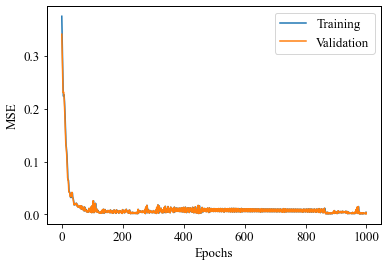

In [19]:
#Plotting the training and validation loss values over epochs
plt.plot(history_separated.history['loss'], label='Training')
plt.plot(history_separated.history['val_loss'], label='Validation')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('Epochs')

In [20]:
#inverse transform the scaled outputs to get original values
y_true_separated = scaler.inverse_transform(Ytest_separated)
y_pred_separated = scaler.inverse_transform(model_separated.predict(xtest_separated))

2024-10-17 15:11:42.141312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


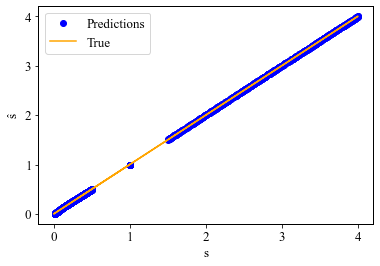

In [21]:
#Create a scatter plot of predicted values for $s$ versus true values
plt.plot(y_pred_separated, y_true_separated, 'bo', label='Predictions')
plt.plot(y_true_separated, y_true_separated, color='orange', label='True')
plt.xlabel(r"$\mathrm{s}$")
plt.ylabel(r"$\mathrm{\hat{s}}$")
plt.legend()
plt.savefig('predictedsvreal_separated.pdf', bbox_inches='tight')

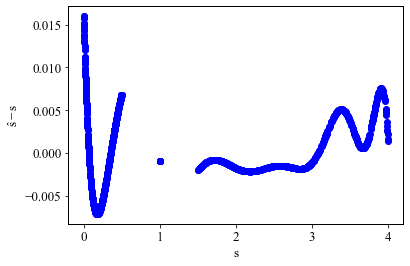

In [22]:
#Create a scatter plot of the difference between the predicted and true values of $s$ versus true values
plt.plot(y_true_separated[y_true_separated.flatten().argsort()], (y_pred_separated - y_true_separated)[y_true_separated.flatten().argsort()], 'bo')
plt.xlabel(r"$\mathrm{s}$")
plt.ylabel(r"$\mathrm{\hat{s} - s}$")
plt.savefig('errorvs_separated.pdf', bbox_inches='tight')

In [23]:
#Generate arrays for the error distribution containing only one Ohmic trajectory
y_true_separated_distrib = np.concatenate((y_true_separated[y_true_separated != 1], y_true_separated[y_true_separated==1][[0]]))
y_pred_separated_distrib = np.concatenate((y_pred_separated[y_true_separated != 1], y_pred_separated[y_true_separated==1][[0]]))

#define an array where each element is the difference between the predicted value and true value for $s$ for a 
#given trajectory
diffs1 = y_pred_separated_distrib - y_true_separated_distrib
#print the minimum difference to find the smallest prediction error
print(np.amin(diffs1))
#print the maximum difference to find the largest prediction error
print(np.amax(diffs1))

-0.007107688068703155
0.01598012678008709


In [27]:
#define intervals for analysing the differences between predicted and true values for $s$
intervals1 = [-0.008, -0.0075, -0.007, -0.0065, -0.006, -0.0055, -0.005, -0.0045, -0.004, -0.0035, -0.003, -0.0025, -0.002, -0.0015, -0.001, -0.0005, 0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065, 0.007, 0.0075, 0.008, 0.0085, 0.009, 0.0095, 0.01, 0.0105, 0.011, 0.0115, 0.012, 0.0125, 0.013, 0.0135, 0.014, 0.0145, 0.015, 0.0155, 0.016]

In [28]:
#initialise list to store the frequencies of differences in intervals for $s$
freq1 = []

#loop through each interval
for i in range(len(intervals1)-1):
    #create a mask to find differences within the current interval
    mask1 = (diffs1 >= intervals1[i]) & (diffs1 < intervals1[i+1])
    #append the count of differences within the current interval to the frequency list
    freq1.append(len(diffs1[mask1]))

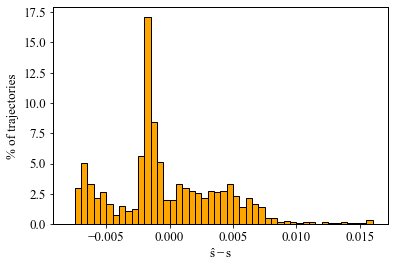

In [30]:
#Calculate x positions for bars and heights
x1 = intervals1[1:] 
heights1 = (np.array(freq1)/len(y_true_separated_distrib))*100

#Create the bar chart
plt.bar(x1, heights1, width=-0.0005, align='edge', alpha = 1, color = 'orange', edgecolor='black')  
plt.xlabel(r"$\mathrm{\hat{s} - s}$")
plt.ylabel('% of trajectories')
plt.savefig('barchart_separated.pdf', bbox_inches='tight')
plt.show()

In [32]:
#Loading the data with $\eta = 0.25$, $\omega_c = 0.5$ with $s \in (0, 1)$ if the spectral density is sub-Ohmic,
#$s \in (1, 4]$ is the spectral density is super-Ohmic and $s=1$ is the spectral density is Ohmic.
X_notseparated = np.loadtxt('Data/Xtrainx_fixedηandω_notseparated.csv', delimiter=',')
Y_notseparated = np.loadtxt('Data/Ytrain_fixedηandω_notseparated.csv', delimiter=',')

In [33]:
#Y_notseparateds[:,[4]] selects the column with the Ohmicity parameter, located at index 4
Y_notseparateds = Y_notseparated[:,[4]]

#Scale the labels using MinMaxScaler for normalisation
scaler=MinMaxScaler()
Y_notseparateds_scaled = scaler.fit_transform(Y_notseparateds)

#Generating a training, validation and test set 
xtrain_notseparated, xval_notseparated, xtest_notseparated, Ytrain_notseparated, Yval_notseparated, Ytest_notseparated = fouriertrainvaltest(X_notseparated, Y_notseparateds_scaled, 4800, 2400, 2400)

In [34]:
#Define the path where the model's weights will be saved
checkpoint_path = "training_regressions_notseparated.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [70]:
#Create a sequential model
model_notseparated = tf.keras.Sequential()
#Add the hidden layers
model_notseparated.add(tf.keras.layers.Dense(250, input_dim = (np.shape(xtrain_notseparated)[1]), activation='sigmoid'))
model_notseparated.add(tf.keras.layers.Dense(80 , activation = 'sigmoid'))
#Add the output layer
model_notseparated.add(tf.keras.layers.Dense(1, activation = 'linear'))

#Setting the optimiser equal to the Adam optimiser with learning rate = 0.0001
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)

#Compliling the model
model_notseparated.compile(optimizer=opt, loss = 'mean_absolute_error', metrics=[r_square])

#Training the model
history_notseparated = model_notseparated.fit(xtrain_notseparated, Ytrain_notseparated, epochs = 1000, validation_data = (xval_notseparated, Yval_notseparated), batch_size = np.shape(xtrain_notseparated)[0], verbose=1, callbacks=[cp_callback])

Epoch 1/1000
1/1 [==============================] - ETA: 0s - loss: 0.3543 - r_square: -1.3332

2024-10-17 15:32:58.881883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-10-17 15:32:59.042241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 339ms/step - loss: 0.3543 - r_square: -1.3332 - val_loss: 0.3153 - val_r_square: -0.8651
Epoch 2/1000
1/1 [==============================] - ETA: 0s - loss: 0.3141 - r_square: -0.8256
Epoch 2: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 37ms/step - loss: 0.3141 - r_square: -0.8256 - val_loss: 0.2776 - val_r_square: -0.4796
Epoch 3/1000
1/1 [==============================] - ETA: 0s - loss: 0.2773 - r_square: -0.4570
Epoch 3: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 39ms/step - loss: 0.2773 - r_square: -0.4570 - val_loss: 0.2430 - val_r_square: -0.2315
Epoch 4/1000
1/1 [==============================] - ETA: 0s - loss: 0.2439 - r_square: -0.2228
Epoch 4: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 4

Epoch 57/1000
1/1 [==============================] - ETA: 0s - loss: 0.0180 - r_square: 0.9917
Epoch 57: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0180 - r_square: 0.9917 - val_loss: 0.0148 - val_r_square: 0.9937
Epoch 58/1000
1/1 [==============================] - ETA: 0s - loss: 0.0153 - r_square: 0.9934
Epoch 58: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0153 - r_square: 0.9934 - val_loss: 0.0102 - val_r_square: 0.9958
Epoch 59/1000
1/1 [==============================] - ETA: 0s - loss: 0.0107 - r_square: 0.9955
Epoch 59: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0107 - r_square: 0.9955 - val_loss: 0.0172 - val_r_square: 0.9935
Epoch 60/1000
1/1 [==============================] - ETA: 0s - loss: 0.0175 - r_square: 0.9933
Epoch 60: saving model 

Epoch 85/1000
1/1 [==============================] - ETA: 0s - loss: 0.0076 - r_square: 0.9982
Epoch 85: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0076 - r_square: 0.9982 - val_loss: 0.0097 - val_r_square: 0.9978
Epoch 86/1000
1/1 [==============================] - ETA: 0s - loss: 0.0099 - r_square: 0.9978
Epoch 86: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0099 - r_square: 0.9978 - val_loss: 0.0109 - val_r_square: 0.9975
Epoch 87/1000
1/1 [==============================] - ETA: 0s - loss: 0.0110 - r_square: 0.9975
Epoch 87: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0110 - r_square: 0.9975 - val_loss: 0.0040 - val_r_square: 0.9989
Epoch 88/1000
1/1 [==============================] - ETA: 0s - loss: 0.0041 - r_square: 0.9989
Epoch 88: saving model 

Epoch 113/1000
1/1 [==============================] - ETA: 0s - loss: 0.0065 - r_square: 0.9991
Epoch 113: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 38ms/step - loss: 0.0065 - r_square: 0.9991 - val_loss: 0.0128 - val_r_square: 0.9972
Epoch 114/1000
1/1 [==============================] - ETA: 0s - loss: 0.0128 - r_square: 0.9973
Epoch 114: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 39ms/step - loss: 0.0128 - r_square: 0.9973 - val_loss: 0.0184 - val_r_square: 0.9944
Epoch 115/1000
1/1 [==============================] - ETA: 0s - loss: 0.0184 - r_square: 0.9945
Epoch 115: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 38ms/step - loss: 0.0184 - r_square: 0.9945 - val_loss: 0.0128 - val_r_square: 0.9972
Epoch 116/1000
1/1 [==============================] - ETA: 0s - loss: 0.0128 - r_square: 0.9973
Epoch 116: savin

Epoch 141/1000
1/1 [==============================] - ETA: 0s - loss: 0.0062 - r_square: 0.9992
Epoch 141: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 32ms/step - loss: 0.0062 - r_square: 0.9992 - val_loss: 0.0105 - val_r_square: 0.9980
Epoch 142/1000
1/1 [==============================] - ETA: 0s - loss: 0.0106 - r_square: 0.9980
Epoch 142: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0106 - r_square: 0.9980 - val_loss: 0.0049 - val_r_square: 0.9995
Epoch 143/1000
1/1 [==============================] - ETA: 0s - loss: 0.0049 - r_square: 0.9995
Epoch 143: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0049 - r_square: 0.9995 - val_loss: 0.0097 - val_r_square: 0.9984
Epoch 144/1000
1/1 [==============================] - ETA: 0s - loss: 0.0097 - r_square: 0.9984
Epoch 144: savin

Epoch 169/1000
1/1 [==============================] - ETA: 0s - loss: 0.0116 - r_square: 0.9977
Epoch 169: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0116 - r_square: 0.9977 - val_loss: 0.0062 - val_r_square: 0.9992
Epoch 170/1000
1/1 [==============================] - ETA: 0s - loss: 0.0063 - r_square: 0.9992
Epoch 170: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0063 - r_square: 0.9992 - val_loss: 0.0081 - val_r_square: 0.9988
Epoch 171/1000
1/1 [==============================] - ETA: 0s - loss: 0.0081 - r_square: 0.9988
Epoch 171: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0081 - r_square: 0.9988 - val_loss: 0.0112 - val_r_square: 0.9978
Epoch 172/1000
1/1 [==============================] - ETA: 0s - loss: 0.0112 - r_square: 0.9979
Epoch 172: savin

Epoch 197/1000
1/1 [==============================] - ETA: 0s - loss: 0.0046 - r_square: 0.9996
Epoch 197: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 44ms/step - loss: 0.0046 - r_square: 0.9996 - val_loss: 0.0097 - val_r_square: 0.9983
Epoch 198/1000
1/1 [==============================] - ETA: 0s - loss: 0.0098 - r_square: 0.9984
Epoch 198: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 37ms/step - loss: 0.0098 - r_square: 0.9984 - val_loss: 0.0131 - val_r_square: 0.9971
Epoch 199/1000
1/1 [==============================] - ETA: 0s - loss: 0.0131 - r_square: 0.9972
Epoch 199: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 37ms/step - loss: 0.0131 - r_square: 0.9972 - val_loss: 0.0072 - val_r_square: 0.9990
Epoch 200/1000
1/1 [==============================] - ETA: 0s - loss: 0.0072 - r_square: 0.9991
Epoch 200: savin

Epoch 225/1000
1/1 [==============================] - ETA: 0s - loss: 0.0086 - r_square: 0.9987
Epoch 225: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0086 - r_square: 0.9987 - val_loss: 0.0123 - val_r_square: 0.9975
Epoch 226/1000
1/1 [==============================] - ETA: 0s - loss: 0.0123 - r_square: 0.9975
Epoch 226: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 31ms/step - loss: 0.0123 - r_square: 0.9975 - val_loss: 0.0068 - val_r_square: 0.9991
Epoch 227/1000
1/1 [==============================] - ETA: 0s - loss: 0.0069 - r_square: 0.9991
Epoch 227: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 31ms/step - loss: 0.0069 - r_square: 0.9991 - val_loss: 0.0065 - val_r_square: 0.9992
Epoch 228/1000
1/1 [==============================] - ETA: 0s - loss: 0.0065 - r_square: 0.9992
Epoch 228: savin

Epoch 253/1000
1/1 [==============================] - ETA: 0s - loss: 0.0091 - r_square: 0.9986
Epoch 253: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 36ms/step - loss: 0.0091 - r_square: 0.9986 - val_loss: 0.0028 - val_r_square: 0.9998
Epoch 254/1000
1/1 [==============================] - ETA: 0s - loss: 0.0027 - r_square: 0.9998
Epoch 254: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 37ms/step - loss: 0.0027 - r_square: 0.9998 - val_loss: 0.0094 - val_r_square: 0.9985
Epoch 255/1000
1/1 [==============================] - ETA: 0s - loss: 0.0094 - r_square: 0.9985
Epoch 255: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 52ms/step - loss: 0.0094 - r_square: 0.9985 - val_loss: 0.0108 - val_r_square: 0.9980
Epoch 256/1000
1/1 [==============================] - ETA: 0s - loss: 0.0108 - r_square: 0.9980
Epoch 256: savin

Epoch 281/1000
1/1 [==============================] - ETA: 0s - loss: 0.0052 - r_square: 0.9995
Epoch 281: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 41ms/step - loss: 0.0052 - r_square: 0.9995 - val_loss: 0.0088 - val_r_square: 0.9987
Epoch 282/1000
1/1 [==============================] - ETA: 0s - loss: 0.0088 - r_square: 0.9987
Epoch 282: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 36ms/step - loss: 0.0088 - r_square: 0.9987 - val_loss: 0.0130 - val_r_square: 0.9972
Epoch 283/1000
1/1 [==============================] - ETA: 0s - loss: 0.0130 - r_square: 0.9972
Epoch 283: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 31ms/step - loss: 0.0130 - r_square: 0.9972 - val_loss: 0.0085 - val_r_square: 0.9987
Epoch 284/1000
1/1 [==============================] - ETA: 0s - loss: 0.0085 - r_square: 0.9988
Epoch 284: savin

Epoch 309/1000
1/1 [==============================] - ETA: 0s - loss: 0.0029 - r_square: 0.9998
Epoch 309: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 31ms/step - loss: 0.0029 - r_square: 0.9998 - val_loss: 0.0072 - val_r_square: 0.9991
Epoch 310/1000
1/1 [==============================] - ETA: 0s - loss: 0.0072 - r_square: 0.9991
Epoch 310: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 36ms/step - loss: 0.0072 - r_square: 0.9991 - val_loss: 0.0029 - val_r_square: 0.9998
Epoch 311/1000
1/1 [==============================] - ETA: 0s - loss: 0.0029 - r_square: 0.9998
Epoch 311: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0029 - r_square: 0.9998 - val_loss: 0.0080 - val_r_square: 0.9989
Epoch 312/1000
1/1 [==============================] - ETA: 0s - loss: 0.0080 - r_square: 0.9989
Epoch 312: savin

Epoch 337/1000
1/1 [==============================] - ETA: 0s - loss: 0.0130 - r_square: 0.9973
Epoch 337: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 38ms/step - loss: 0.0130 - r_square: 0.9973 - val_loss: 0.0071 - val_r_square: 0.9991
Epoch 338/1000
1/1 [==============================] - ETA: 0s - loss: 0.0071 - r_square: 0.9992
Epoch 338: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 60ms/step - loss: 0.0071 - r_square: 0.9992 - val_loss: 0.0063 - val_r_square: 0.9993
Epoch 339/1000
1/1 [==============================] - ETA: 0s - loss: 0.0063 - r_square: 0.9993
Epoch 339: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 54ms/step - loss: 0.0063 - r_square: 0.9993 - val_loss: 0.0101 - val_r_square: 0.9983
Epoch 340/1000
1/1 [==============================] - ETA: 0s - loss: 0.0101 - r_square: 0.9983
Epoch 340: savin

Epoch 365/1000
1/1 [==============================] - ETA: 0s - loss: 0.0046 - r_square: 0.9996
Epoch 365: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0046 - r_square: 0.9996 - val_loss: 0.0075 - val_r_square: 0.9990
Epoch 366/1000
1/1 [==============================] - ETA: 0s - loss: 0.0075 - r_square: 0.9990
Epoch 366: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0075 - r_square: 0.9990 - val_loss: 0.0104 - val_r_square: 0.9982
Epoch 367/1000
1/1 [==============================] - ETA: 0s - loss: 0.0104 - r_square: 0.9982
Epoch 367: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0104 - r_square: 0.9982 - val_loss: 0.0051 - val_r_square: 0.9995
Epoch 368/1000
1/1 [==============================] - ETA: 0s - loss: 0.0051 - r_square: 0.9995
Epoch 368: savin

Epoch 393/1000
1/1 [==============================] - ETA: 0s - loss: 0.0067 - r_square: 0.9992
Epoch 393: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0067 - r_square: 0.9992 - val_loss: 0.0094 - val_r_square: 0.9985
Epoch 394/1000
1/1 [==============================] - ETA: 0s - loss: 0.0094 - r_square: 0.9985
Epoch 394: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0094 - r_square: 0.9985 - val_loss: 0.0041 - val_r_square: 0.9996
Epoch 395/1000
1/1 [==============================] - ETA: 0s - loss: 0.0041 - r_square: 0.9997
Epoch 395: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0041 - r_square: 0.9997 - val_loss: 0.0075 - val_r_square: 0.9990
Epoch 396/1000
1/1 [==============================] - ETA: 0s - loss: 0.0076 - r_square: 0.9990
Epoch 396: savin

Epoch 421/1000
1/1 [==============================] - ETA: 0s - loss: 0.0114 - r_square: 0.9979
Epoch 421: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0114 - r_square: 0.9979 - val_loss: 0.0063 - val_r_square: 0.9993
Epoch 422/1000
1/1 [==============================] - ETA: 0s - loss: 0.0064 - r_square: 0.9993
Epoch 422: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 36ms/step - loss: 0.0064 - r_square: 0.9993 - val_loss: 0.0058 - val_r_square: 0.9994
Epoch 423/1000
1/1 [==============================] - ETA: 0s - loss: 0.0058 - r_square: 0.9994
Epoch 423: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 37ms/step - loss: 0.0058 - r_square: 0.9994 - val_loss: 0.0090 - val_r_square: 0.9986
Epoch 424/1000
1/1 [==============================] - ETA: 0s - loss: 0.0090 - r_square: 0.9986
Epoch 424: savin

Epoch 449/1000
1/1 [==============================] - ETA: 0s - loss: 0.0059 - r_square: 0.9993
Epoch 449: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0059 - r_square: 0.9993 - val_loss: 0.0061 - val_r_square: 0.9993
Epoch 450/1000
1/1 [==============================] - ETA: 0s - loss: 0.0061 - r_square: 0.9993
Epoch 450: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0061 - r_square: 0.9993 - val_loss: 0.0093 - val_r_square: 0.9985
Epoch 451/1000
1/1 [==============================] - ETA: 0s - loss: 0.0093 - r_square: 0.9986
Epoch 451: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0093 - r_square: 0.9986 - val_loss: 0.0047 - val_r_square: 0.9996
Epoch 452/1000
1/1 [==============================] - ETA: 0s - loss: 0.0047 - r_square: 0.9996
Epoch 452: savin

Epoch 477/1000
1/1 [==============================] - ETA: 0s - loss: 0.0049 - r_square: 0.9995
Epoch 477: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 135ms/step - loss: 0.0049 - r_square: 0.9995 - val_loss: 0.0077 - val_r_square: 0.9990
Epoch 478/1000
1/1 [==============================] - ETA: 0s - loss: 0.0077 - r_square: 0.9990
Epoch 478: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 47ms/step - loss: 0.0077 - r_square: 0.9990 - val_loss: 0.0029 - val_r_square: 0.9998
Epoch 479/1000
1/1 [==============================] - ETA: 0s - loss: 0.0029 - r_square: 0.9998
Epoch 479: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 36ms/step - loss: 0.0029 - r_square: 0.9998 - val_loss: 0.0080 - val_r_square: 0.9989
Epoch 480/1000
1/1 [==============================] - ETA: 0s - loss: 0.0080 - r_square: 0.9989
Epoch 480: savi

Epoch 505/1000
1/1 [==============================] - ETA: 0s - loss: 0.0103 - r_square: 0.9982
Epoch 505: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0103 - r_square: 0.9982 - val_loss: 0.0058 - val_r_square: 0.9994
Epoch 506/1000
1/1 [==============================] - ETA: 0s - loss: 0.0058 - r_square: 0.9994
Epoch 506: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 32ms/step - loss: 0.0058 - r_square: 0.9994 - val_loss: 0.0057 - val_r_square: 0.9994
Epoch 507/1000
1/1 [==============================] - ETA: 0s - loss: 0.0057 - r_square: 0.9994
Epoch 507: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0057 - r_square: 0.9994 - val_loss: 0.0085 - val_r_square: 0.9987
Epoch 508/1000
1/1 [==============================] - ETA: 0s - loss: 0.0085 - r_square: 0.9988
Epoch 508: savin

Epoch 533/1000
1/1 [==============================] - ETA: 0s - loss: 0.0033 - r_square: 0.9998
Epoch 533: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0033 - r_square: 0.9998 - val_loss: 0.0074 - val_r_square: 0.9990
Epoch 534/1000
1/1 [==============================] - ETA: 0s - loss: 0.0074 - r_square: 0.9990
Epoch 534: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0074 - r_square: 0.9990 - val_loss: 0.0096 - val_r_square: 0.9984
Epoch 535/1000
1/1 [==============================] - ETA: 0s - loss: 0.0096 - r_square: 0.9984
Epoch 535: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0096 - r_square: 0.9984 - val_loss: 0.0043 - val_r_square: 0.9996
Epoch 536/1000
1/1 [==============================] - ETA: 0s - loss: 0.0043 - r_square: 0.9996
Epoch 536: savin

Epoch 561/1000
1/1 [==============================] - ETA: 0s - loss: 0.0060 - r_square: 0.9993
Epoch 561: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0060 - r_square: 0.9993 - val_loss: 0.0092 - val_r_square: 0.9986
Epoch 562/1000
1/1 [==============================] - ETA: 0s - loss: 0.0092 - r_square: 0.9986
Epoch 562: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 42ms/step - loss: 0.0092 - r_square: 0.9986 - val_loss: 0.0047 - val_r_square: 0.9996
Epoch 563/1000
1/1 [==============================] - ETA: 0s - loss: 0.0047 - r_square: 0.9996
Epoch 563: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0047 - r_square: 0.9996 - val_loss: 0.0067 - val_r_square: 0.9992
Epoch 564/1000
1/1 [==============================] - ETA: 0s - loss: 0.0067 - r_square: 0.9992
Epoch 564: savin

Epoch 589/1000
1/1 [==============================] - ETA: 0s - loss: 0.0087 - r_square: 0.9987
Epoch 589: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0087 - r_square: 0.9987 - val_loss: 0.0032 - val_r_square: 0.9998
Epoch 590/1000
1/1 [==============================] - ETA: 0s - loss: 0.0031 - r_square: 0.9998
Epoch 590: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0031 - r_square: 0.9998 - val_loss: 0.0069 - val_r_square: 0.9991
Epoch 591/1000
1/1 [==============================] - ETA: 0s - loss: 0.0070 - r_square: 0.9991
Epoch 591: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0070 - r_square: 0.9991 - val_loss: 0.0083 - val_r_square: 0.9988
Epoch 592/1000
1/1 [==============================] - ETA: 0s - loss: 0.0083 - r_square: 0.9988
Epoch 592: savin

Epoch 617/1000
1/1 [==============================] - ETA: 0s - loss: 0.0029 - r_square: 0.9998
Epoch 617: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0029 - r_square: 0.9998 - val_loss: 0.0076 - val_r_square: 0.9990
Epoch 618/1000
1/1 [==============================] - ETA: 0s - loss: 0.0076 - r_square: 0.9990
Epoch 618: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0076 - r_square: 0.9990 - val_loss: 0.0098 - val_r_square: 0.9984
Epoch 619/1000
1/1 [==============================] - ETA: 0s - loss: 0.0098 - r_square: 0.9984
Epoch 619: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0098 - r_square: 0.9984 - val_loss: 0.0046 - val_r_square: 0.9996
Epoch 620/1000
1/1 [==============================] - ETA: 0s - loss: 0.0047 - r_square: 0.9996
Epoch 620: savin

Epoch 645/1000
1/1 [==============================] - ETA: 0s - loss: 0.0055 - r_square: 0.9995
Epoch 645: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0055 - r_square: 0.9995 - val_loss: 0.0082 - val_r_square: 0.9989
Epoch 646/1000
1/1 [==============================] - ETA: 0s - loss: 0.0082 - r_square: 0.9989
Epoch 646: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0082 - r_square: 0.9989 - val_loss: 0.0035 - val_r_square: 0.9997
Epoch 647/1000
1/1 [==============================] - ETA: 0s - loss: 0.0035 - r_square: 0.9997
Epoch 647: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 36ms/step - loss: 0.0035 - r_square: 0.9997 - val_loss: 0.0079 - val_r_square: 0.9989
Epoch 648/1000
1/1 [==============================] - ETA: 0s - loss: 0.0079 - r_square: 0.9989
Epoch 648: savin

Epoch 673/1000
1/1 [==============================] - ETA: 0s - loss: 0.0093 - r_square: 0.9986
Epoch 673: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0093 - r_square: 0.9986 - val_loss: 0.0039 - val_r_square: 0.9997
Epoch 674/1000
1/1 [==============================] - ETA: 0s - loss: 0.0039 - r_square: 0.9997
Epoch 674: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0039 - r_square: 0.9997 - val_loss: 0.0071 - val_r_square: 0.9991
Epoch 675/1000
1/1 [==============================] - ETA: 0s - loss: 0.0071 - r_square: 0.9991
Epoch 675: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0071 - r_square: 0.9991 - val_loss: 0.0097 - val_r_square: 0.9984
Epoch 676/1000
1/1 [==============================] - ETA: 0s - loss: 0.0097 - r_square: 0.9984
Epoch 676: savin

Epoch 701/1000
1/1 [==============================] - ETA: 0s - loss: 0.0019 - r_square: 0.9999
Epoch 701: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0019 - r_square: 0.9999 - val_loss: 0.0035 - val_r_square: 0.9997
Epoch 702/1000
1/1 [==============================] - ETA: 0s - loss: 0.0035 - r_square: 0.9997
Epoch 702: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0035 - r_square: 0.9997 - val_loss: 0.0029 - val_r_square: 0.9998
Epoch 703/1000
1/1 [==============================] - ETA: 0s - loss: 0.0029 - r_square: 0.9998
Epoch 703: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0029 - r_square: 0.9998 - val_loss: 0.0027 - val_r_square: 0.9998
Epoch 704/1000
1/1 [==============================] - ETA: 0s - loss: 0.0027 - r_square: 0.9998
Epoch 704: savin

Epoch 729/1000
1/1 [==============================] - ETA: 0s - loss: 0.0011 - r_square: 1.0000
Epoch 729: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0011 - r_square: 1.0000 - val_loss: 0.0024 - val_r_square: 0.9999
Epoch 730/1000
1/1 [==============================] - ETA: 0s - loss: 0.0024 - r_square: 0.9999
Epoch 730: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0024 - r_square: 0.9999 - val_loss: 0.0022 - val_r_square: 0.9999
Epoch 731/1000
1/1 [==============================] - ETA: 0s - loss: 0.0022 - r_square: 0.9999
Epoch 731: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0022 - r_square: 0.9999 - val_loss: 0.0012 - val_r_square: 0.9999
Epoch 732/1000
1/1 [==============================] - ETA: 0s - loss: 0.0013 - r_square: 0.9999
Epoch 732: savin

Epoch 757/1000
1/1 [==============================] - ETA: 0s - loss: 0.0059 - r_square: 0.9994
Epoch 757: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0059 - r_square: 0.9994 - val_loss: 0.0055 - val_r_square: 0.9995
Epoch 758/1000
1/1 [==============================] - ETA: 0s - loss: 0.0055 - r_square: 0.9995
Epoch 758: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0055 - r_square: 0.9995 - val_loss: 0.0022 - val_r_square: 0.9999
Epoch 759/1000
1/1 [==============================] - ETA: 0s - loss: 0.0023 - r_square: 0.9999
Epoch 759: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 36ms/step - loss: 0.0023 - r_square: 0.9999 - val_loss: 0.0021 - val_r_square: 0.9999
Epoch 760/1000
1/1 [==============================] - ETA: 0s - loss: 0.0022 - r_square: 0.9999
Epoch 760: savin

Epoch 785/1000
1/1 [==============================] - ETA: 0s - loss: 0.0011 - r_square: 1.0000
Epoch 785: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0011 - r_square: 1.0000 - val_loss: 0.0021 - val_r_square: 0.9999
Epoch 786/1000
1/1 [==============================] - ETA: 0s - loss: 0.0021 - r_square: 0.9999
Epoch 786: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0021 - r_square: 0.9999 - val_loss: 0.0029 - val_r_square: 0.9999
Epoch 787/1000
1/1 [==============================] - ETA: 0s - loss: 0.0030 - r_square: 0.9999
Epoch 787: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0030 - r_square: 0.9999 - val_loss: 0.0011 - val_r_square: 1.0000
Epoch 788/1000
1/1 [==============================] - ETA: 0s - loss: 0.0011 - r_square: 1.0000
Epoch 788: savin

Epoch 813/1000
1/1 [==============================] - ETA: 0s - loss: 0.0126 - r_square: 0.9975
Epoch 813: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0126 - r_square: 0.9975 - val_loss: 0.0166 - val_r_square: 0.9956
Epoch 814/1000
1/1 [==============================] - ETA: 0s - loss: 0.0166 - r_square: 0.9957
Epoch 814: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 36ms/step - loss: 0.0166 - r_square: 0.9957 - val_loss: 0.0130 - val_r_square: 0.9973
Epoch 815/1000
1/1 [==============================] - ETA: 0s - loss: 0.0130 - r_square: 0.9973
Epoch 815: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0130 - r_square: 0.9973 - val_loss: 0.0027 - val_r_square: 0.9999
Epoch 816/1000
1/1 [==============================] - ETA: 0s - loss: 0.0027 - r_square: 0.9999
Epoch 816: savin

Epoch 841/1000
1/1 [==============================] - ETA: 0s - loss: 0.0083 - r_square: 0.9989
Epoch 841: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 35ms/step - loss: 0.0083 - r_square: 0.9989 - val_loss: 0.0040 - val_r_square: 0.9997
Epoch 842/1000
1/1 [==============================] - ETA: 0s - loss: 0.0041 - r_square: 0.9997
Epoch 842: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0041 - r_square: 0.9997 - val_loss: 0.0068 - val_r_square: 0.9992
Epoch 843/1000
1/1 [==============================] - ETA: 0s - loss: 0.0069 - r_square: 0.9992
Epoch 843: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0069 - r_square: 0.9992 - val_loss: 0.0095 - val_r_square: 0.9985
Epoch 844/1000
1/1 [==============================] - ETA: 0s - loss: 0.0095 - r_square: 0.9985
Epoch 844: savin

Epoch 869/1000
1/1 [==============================] - ETA: 0s - loss: 0.0042 - r_square: 0.9997
Epoch 869: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0042 - r_square: 0.9997 - val_loss: 0.0069 - val_r_square: 0.9992
Epoch 870/1000
1/1 [==============================] - ETA: 0s - loss: 0.0069 - r_square: 0.9992
Epoch 870: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0069 - r_square: 0.9992 - val_loss: 0.0098 - val_r_square: 0.9984
Epoch 871/1000
1/1 [==============================] - ETA: 0s - loss: 0.0099 - r_square: 0.9985
Epoch 871: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0099 - r_square: 0.9985 - val_loss: 0.0054 - val_r_square: 0.9995
Epoch 872/1000
1/1 [==============================] - ETA: 0s - loss: 0.0054 - r_square: 0.9995
Epoch 872: savin

Epoch 897/1000
1/1 [==============================] - ETA: 0s - loss: 0.0041 - r_square: 0.9997
Epoch 897: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0041 - r_square: 0.9997 - val_loss: 0.0069 - val_r_square: 0.9992
Epoch 898/1000
1/1 [==============================] - ETA: 0s - loss: 0.0069 - r_square: 0.9992
Epoch 898: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 37ms/step - loss: 0.0069 - r_square: 0.9992 - val_loss: 0.0025 - val_r_square: 0.9999
Epoch 899/1000
1/1 [==============================] - ETA: 0s - loss: 0.0024 - r_square: 0.9999
Epoch 899: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 37ms/step - loss: 0.0024 - r_square: 0.9999 - val_loss: 0.0085 - val_r_square: 0.9988
Epoch 900/1000
1/1 [==============================] - ETA: 0s - loss: 0.0085 - r_square: 0.9988
Epoch 900: savin

Epoch 925/1000
1/1 [==============================] - ETA: 0s - loss: 0.0093 - r_square: 0.9986
Epoch 925: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0093 - r_square: 0.9986 - val_loss: 0.0050 - val_r_square: 0.9996
Epoch 926/1000
1/1 [==============================] - ETA: 0s - loss: 0.0050 - r_square: 0.9996
Epoch 926: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0050 - r_square: 0.9996 - val_loss: 0.0058 - val_r_square: 0.9994
Epoch 927/1000
1/1 [==============================] - ETA: 0s - loss: 0.0058 - r_square: 0.9995
Epoch 927: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0058 - r_square: 0.9995 - val_loss: 0.0085 - val_r_square: 0.9988
Epoch 928/1000
1/1 [==============================] - ETA: 0s - loss: 0.0086 - r_square: 0.9988
Epoch 928: savin

Epoch 953/1000
1/1 [==============================] - ETA: 0s - loss: 0.0041 - r_square: 0.9997
Epoch 953: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0041 - r_square: 0.9997 - val_loss: 0.0067 - val_r_square: 0.9992
Epoch 954/1000
1/1 [==============================] - ETA: 0s - loss: 0.0067 - r_square: 0.9992
Epoch 954: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 33ms/step - loss: 0.0067 - r_square: 0.9992 - val_loss: 0.0095 - val_r_square: 0.9985
Epoch 955/1000
1/1 [==============================] - ETA: 0s - loss: 0.0095 - r_square: 0.9985
Epoch 955: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0095 - r_square: 0.9985 - val_loss: 0.0051 - val_r_square: 0.9995
Epoch 956/1000
1/1 [==============================] - ETA: 0s - loss: 0.0052 - r_square: 0.9995
Epoch 956: savin

Epoch 981/1000
1/1 [==============================] - ETA: 0s - loss: 0.0047 - r_square: 0.9996
Epoch 981: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0047 - r_square: 0.9996 - val_loss: 0.0075 - val_r_square: 0.9991
Epoch 982/1000
1/1 [==============================] - ETA: 0s - loss: 0.0075 - r_square: 0.9991
Epoch 982: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0075 - r_square: 0.9991 - val_loss: 0.0032 - val_r_square: 0.9998
Epoch 983/1000
1/1 [==============================] - ETA: 0s - loss: 0.0031 - r_square: 0.9998
Epoch 983: saving model to training_regressions_notseparated.weights.h5
1/1 [==============================] - 0s 34ms/step - loss: 0.0031 - r_square: 0.9998 - val_loss: 0.0070 - val_r_square: 0.9992
Epoch 984/1000
1/1 [==============================] - ETA: 0s - loss: 0.0070 - r_square: 0.9991
Epoch 984: savin

In [71]:
#Evaluating the model on the training set
model_notseparated.evaluate(xtrain_notseparated, Ytrain_notseparated)

 36/150 [======>.......................] - ETA: 0s - loss: 0.0051 - r_square: 0.9995

2024-10-17 15:33:39.071537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - 0s 3ms/step - loss: 0.0050 - r_square: 0.9995


[0.005009652581065893, 0.9995163083076477]

In [72]:
#Evaluating the model on the test set
model_notseparated.evaluate(xtest_notseparated, Ytest_notseparated)

75/75 [==============================] - 0s 2ms/step - loss: 0.0050 - r_square: 0.9995


[0.005008801352232695, 0.999495267868042]

Text(0, 0.5, 'MSE')

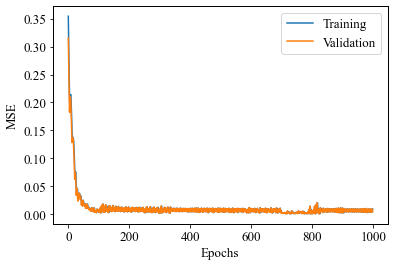

In [73]:
#Plotting the training and validation loss values over epochs
plt.plot(history_notseparated.history['loss'], label='Training')
plt.plot(history_notseparated.history['val_loss'], label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')

In [74]:
#inverse transform the scaled outputs to get original values
y_true_notseparated = scaler.inverse_transform(Ytest_notseparated)
y_pred_notseparated = scaler.inverse_transform(model_notseparated.predict(xtest_notseparated))

2024-10-17 15:33:41.906014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


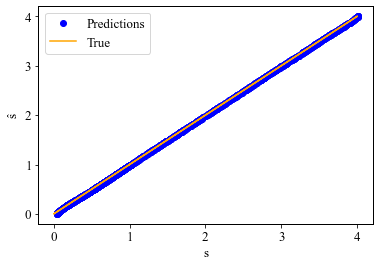

In [75]:
#Create a scatter plot of predicted values for $s$ versus true values
plt.plot(y_pred_notseparated, y_true_notseparated, 'bo', label='Predictions')
plt.plot(y_true_notseparated, y_true_notseparated, color='orange', label='True')
plt.xlabel(r"$\mathrm{s}$")
plt.ylabel(r"$\mathrm{\hat{s}}$")
plt.legend()
plt.savefig('predictedsvreal_notseparated.pdf', bbox_inches='tight')

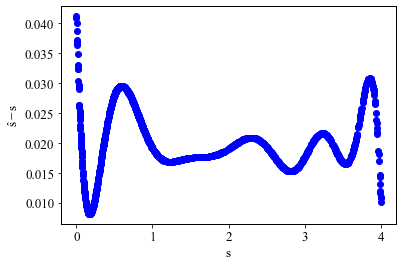

In [76]:
#Create a scatter plot of the difference between the predicted and true values of $s$ versus true values
plt.plot(y_true_notseparated[y_true_notseparated.flatten().argsort()], (y_pred_notseparated - y_true_notseparated)[y_true_notseparated.flatten().argsort()], 'bo')
plt.xlabel(r"$\mathrm{s}$")
plt.ylabel(r"$\mathrm{\hat{s} - s}$")
plt.savefig('errorvs_notseparated.pdf', bbox_inches='tight')

In [77]:
#Generate arrays for the error distribution containing only one Ohmic trajectory
y_true_notseparated_distrib = np.concatenate((y_true_notseparated[y_true_notseparated != 1], y_true_notseparated[y_true_notseparated==1][[0]]))
y_pred_notseparated_distrib = np.concatenate((y_pred_notseparated[y_true_notseparated != 1], y_pred_notseparated[y_true_notseparated == 1][[0]]))

#define an array where each element is the difference between the predicted value and true value for $s$ for a 
#given trajectory
diffs2 = y_pred_notseparated_distrib - y_true_notseparated_distrib
#print the minimum difference to find the smallest prediction error
print(np.amin(diffs2))
#print the maximum difference to find the largest prediction error
print(np.amax(diffs2))

0.008199982674535922
0.04120591177345723


In [83]:
#define intervals for analysing the differences between predicted and true values for $s$
intervals2 = [0.008, 0.0085, 0.009, 0.0095, 0.01, 0.0105, 0.011, 0.0115, 0.012, 0.0125, 0.013, 0.0135, 0.014, 0.0145, 0.015, 0.0155, 0.016, 0.0165, 0.017, 0.0175, 0.018, 0.0185, 0.019, 0.0195, 0.02, 0.0205, 0.021, 0.0215, 0.022, 0.0225, 0.023, 0.0235, 0.024, 0.0245, 0.025, 0.0255, 0.026, 0.0265, 0.027, 0.0275, 0.028, 0.0285, 0.029, 0.0295, 0.03, 0.0305, 0.031, 0.0315, 0.032, 0.0325, 0.033, 0.0335, 0.034, 0.0345, 0.035, 0.0355, 0.036, 0.0365, 0.037, 0.0375, 0.038, 0.0385, 0.039, 0.0395, 0.04, 0.0405, 0.041, 0.0415]

In [84]:
#initialise list to store the frequencies of differences in intervals for $s$
freq2 = []

#loop through each interval
for i in range(len(intervals2)-1):
    #create a mask to find differences within the current interval
    mask2 = (diffs2 >= intervals2[i]) & (diffs2 < intervals2[i+1])
    #append the count of differences within the current interval to the frequency list
    freq2.append(len(diffs2[mask2]))

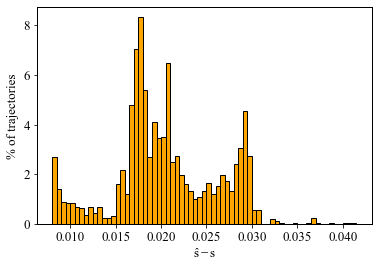

In [86]:
#calculate x positions for bars and heights
x2 = intervals2[1:] 
heights2 = (np.array(freq2)/len(y_true_notseparated_distrib))*100

#create the bar chart
plt.bar(x2, heights2, width=-0.0005, align='edge', alpha = 1, color = 'orange', edgecolor='black')  
plt.xlabel(r"$\mathrm{\hat{s} - s}$")
plt.ylabel('% of trajectories')
plt.savefig('barchart_notseparated.pdf', bbox_inches='tight')
plt.show()